# Decoder object

Nilearn has since release 0.7.0 a new decoder object:

- `nilearn.decoding.Decoder` for classification and 
- `nilearn.decoding.DecoderRegressor` for regression

The decoder object implements a model selection scheme that averages the best models within a cross validation loop.

## Outline

- <a href="#decoding">I. What is decoding?</a>
- <a href="#classif">II. Decoder for classification</a>
    - <a href="#classif-example">Example</a>
        - <a href="#classif-example-data">Get the data</a>
        - <a href="#classif-example-decoding">Decoding pipeline</a>
        - <a href="#classif-example-cross">How to perform cross validation?</a>
        - <a href="#classif-example-leave">Leave one group out cross validation</a>
        - <a href="#classif-example-chance">What is the chance level accuracy?</a>
    - <a href="#classif-compare">Why is the decoder useful?</a>
    - <a href="#classif-custom">Provide custom estimators to the Decoder</a>
- <a href="#regression">III. Decoder for Regression</a>
- <a href="#references">IV. References</a>

<span id="decoding"></span>

## I - What is decoding?

Decoding can be seen as the task of predicting from fMRI activity. A good example is the Haxby experiment in which subjects were presented visual stimuli from different categories. Decoding in this context means predicting which category the subject is seeing from the fMRI activity recorded in regions of the ventral visual system. Significant prediction shows that the signal in the region contains information on the corresponding category.

**TODO: Add a picture here**

<div class="alert alert-block alert-info">
<b>Tip:</b> If you are not familiar with decoding, we recommand that you read the <em>introduction to decoding</em> tutorial on nilearn's website <a href="http://nilearn.github.io/decoding/decoding_intro.html">here</a>.</div>

<span id="classif"></span>

## II - Decoder for classification

First of all, make sure you have nilearn >= 0.7.0 installed:

In [1]:
import nilearn
print(nilearn.__version__)

0.7.2.dev


The documentation for the classification decoder is available on the website [here](http://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html#nilearn.decoding.Decoder), or through the Jupyter magic command:

In [2]:
from nilearn.decoding import Decoder
?Decoder

Init signature:
Decoder(
    estimator='svc',
    mask=None,
    cv=10,
    param_grid=None,
    screening_percentile=20,
    scoring='roc_auc',
    smoothing_fwhm=None,
    standardize=True,
    target_affine=None,
    target_shape=None,
    mask_strategy='background',
    low_pass=None,
    high_pass=None,
    t_r=None,
    memory=None,
    memory_level=0,
    n_jobs=1,
    verbose=0,
)
Docstring:     
A wrapper for popular classification strategies in neuroimaging.

The `Decoder` object supports classification methods.
It implements a model selection scheme that averages the best models
within a cross validation loop. The resulting average model is the
one used as a classifier. This object also leverages the`NiftiMaskers` to
provide a direct interface with the Nifti files on disk.

Parameters
-----------
estimator: str, optional
    The estimator to choose among: 'svc', 'svc_l2', 'svc_l1', 'logistic',
    'logistic_l1', 'logistic_l2' and 'ridge_classifier'. Note that
    'svc' and '

<span id="classif-example"></span>

### Example

<span id="classif-example-data"></span>

#### Get the data

As an example, we will use the Haxby dataset:

In [3]:
from nilearn.datasets import fetch_haxby

haxby_dataset = fetch_haxby()
haxby_dataset.keys()

/home/nicolas/GitRepos/nilearn-fork/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description'])

In [4]:
from nilearn.image import load_img
load_img(haxby_dataset.func[0]).shape

(40, 64, 64, 1452)

As we can see, the data is quite large and contains many conditions:

In [5]:
# Load behavioral information
import pandas as pd

behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
print(behavioral)

     labels  chunks
0      rest       0
1      rest       0
2      rest       0
3      rest       0
4      rest       0
...     ...     ...
1447   rest      11
1448   rest      11
1449   rest      11
1450   rest      11
1451   rest      11

[1452 rows x 2 columns]


In [6]:
# What conditions do we have in this dataset?
import numpy as np
conditions = behavioral['labels']
np.unique(conditions)

array(['bottle', 'cat', 'chair', 'face', 'house', 'rest', 'scissors',
       'scrambledpix', 'shoe'], dtype=object)

In order to simplify this example, we will focus only on `cats` and `faces` signals. We need to drop all data unrelated to these signals. One way to do that is to create a condition mask:

In [7]:
condition_mask = conditions.isin(['face', 'cat'])

We can then use this condition mask to restrict our analysis to cats and faces:

In [8]:
from nilearn.image import index_img

cats_and_faces_data = index_img(haxby_dataset.func[0], 
                                condition_mask)
load_img(cats_and_faces_data).shape

(40, 64, 64, 216)

In [9]:
conditions = conditions[condition_mask].values
conditions.shape

(216,)

We have now a much smaller dataset to work on.

<span id="classif-example-decoding"></span>

#### Decoding basic pipeline

We now have everything we need to do some decoding.

The Decoder object follows the usual `fit`, `transform`, `predict` pattern from scikit-learn such that you usually follow the following pattern:

- Instanciate the Decoder with chosen parameters (estimator, mask...)
- Fit the decoder on training set
- Predict on testing set

In [10]:
decoder = Decoder(estimator='svc',               # Use Support Vector Classifier 
                  mask=haxby_dataset.mask_vt[0], # Provide a mask of the Ventral Temporal cortex
                  standardize=True)              # Standardize time series

Lets pretend we have a training set and a test set by leaving out the last 30 samples and predicting on these samples:

In [11]:
train = index_img(cats_and_faces_data, slice(0, -30))    # train set is all but last 30 samples
test  = index_img(cats_and_faces_data, slice(-30, None)) # test set is only the last 30 samples
conditions_train = conditions[:-30]
conditions_test = conditions[-30:]

# We fit our decoder on the train set
decoder.fit(train, conditions_train)

# And predict on the test set
prediction = decoder.predict(test)

In order to quantify how well we are doing, we can compute the prediction accuracy on the test set, which is the proportion of correctly classified samples:

In [12]:
print("Prediction Accuracy: {:.3f}".format(
    (prediction == conditions_test).sum() / float(len(conditions_test))))

Prediction Accuracy: 0.767


<span id="classif-example-cross"></span>

#### Cross Validation

The decoder also implements a cross-validation loop by default and returns an array of shape (cross-validation parameters, n_folds). We can use accuracy score to measure its performance by defining accuracy as the scoring parameter.

In [13]:
n_folds = 5
decoder = Decoder(estimator='svc', 
                  mask=haxby_dataset.mask_vt[0],
                  standardize=True,
                  cv=n_folds,
                  scoring='accuracy')
decoder.fit(cats_and_faces_data,
            conditions)

We can then check the scores and best performing params per fold:

In [14]:
decoder.cv_scores_

{'cat': [0.9772727272727273,
  0.7906976744186046,
  0.7441860465116279,
  0.8372093023255814,
  0.813953488372093],
 'face': [0.9772727272727273,
  0.7906976744186046,
  0.7441860465116279,
  0.8372093023255814,
  0.813953488372093]}

In [15]:
decoder.cv_params_

{'cat': {'C': [100.0, 100.0, 100.0, 100.0, 100.0]},
 'face': {'C': [100.0, 100.0, 100.0, 100.0, 100.0]}}

<span id="classif-example-leave"></span>

#### Leave one group out cross validation

The best way to do cross-validation is to respect the structure of the experiment, for instance by leaving out full sessions of acquisition.

The number of the session is stored in the CSV file giving the behavioral data. We have to apply our session mask, to select only cats and faces.

In [16]:
session_label = behavioral['chunks'][condition_mask]

The fMRI data is acquired by sessions, and the noise is autocorrelated in a given session. Hence, it is better to predict across sessions when doing cross-validation. To leave a session out, pass the cross-validator object to the cv parameter of decoder.

In [17]:
from sklearn.model_selection import LeaveOneGroupOut
cv = LeaveOneGroupOut()

decoder = Decoder(estimator='svc', 
                  mask=haxby_dataset.mask_vt[0], 
                  standardize=True,
                  cv=cv)
decoder.fit(cats_and_faces_data, 
            conditions, 
            groups=session_label)
print(decoder.cv_scores_)

{'cat': [1.0, 1.0, 1.0, 1.0, 0.9629629629629629, 0.8518518518518519, 0.9753086419753086, 0.40740740740740744, 0.9876543209876543, 1.0, 0.9259259259259259, 0.8765432098765432], 'face': [1.0, 1.0, 1.0, 1.0, 0.9629629629629629, 0.8518518518518519, 0.9753086419753086, 0.40740740740740744, 0.9876543209876543, 1.0, 0.9259259259259259, 0.8765432098765432]}


<span id="classif-example-chance"></span>

#### Chance level accuracy

Does the model above perform better than chance? 

To answer this question, we measure a score at random using simple strategies that are implemented in the `Decoder` object. This is useful to inspect the decoding performance by comparing to a score at chance.

Let’s define a object with Dummy estimator replacing ‘svc’ for classification setting. This object initializes estimator with default dummy strategy.

In [18]:
dummy_decoder = Decoder(estimator='dummy_classifier', 
                        mask=haxby_dataset.mask_vt[0],
                        cv=cv)
dummy_decoder.fit(cats_and_faces_data, 
                  conditions, 
                  groups=session_label)
# Now, we can compare these scores by simply taking a mean over folds
print(dummy_decoder.cv_scores_)

{'cat': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'face': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}


<span id="classif-compare"></span>

### Why is the decoder object useful?

When using the decoder object, a lot of things happen in the background. The purpose of this section is to give you a better understanding of the hidden steps which take place when using the Decoder. Even if the goal of the decoder is to abstract these pipelines to make them "easy" to use, it is good to keep in mind what's going on behin the scene.

By explaining these steps and comparing them with the simplicity of use of the decoder, we also aim at showcasing the straightforwardness of this object.

Let's keep the same example as before, but we decode as if the decoder didn't exist...

**Step 1: Build input X from the nifti image**

Scikit-learn estimators work with 2D (n_sample,n_feature) matrices, not with 4D images. We need to transform our input in such a matrix. Hopefully, we can rely on masker objects from nilearn to do that. Here, we use the `NiftiMasker` with the provided mask to perform this operation:

In [19]:
from nilearn.input_data import NiftiMasker

masker = NiftiMasker(haxby_dataset.mask_vt[0],
                     standardize=True)
X = masker.fit_transform(cats_and_faces_data)
X.shape

(216, 464)

**Step 2: Preprocess our labels to build y**

Now that we have X, we need to take care of the target y. So far we have a vector of string labels that we are going to encode as binary labels using scikit-learn `LabelBinarizer` preprocessor:

In [20]:
from sklearn.preprocessing import LabelBinarizer

target_encoder = LabelBinarizer(pos_label=1, 
                                neg_label=-1)
y = target_encoder.fit_transform(conditions)
# Make sure we have as many samples as we have labels...
assert X.shape[0] == y.shape[0]
y.shape

(216, 1)

**Step 3: Choose an estimator**

Now that we have both X and y ready, we need to come up with a model. To keep things simple here, we will stick with the decoder default estimator for classification: `LinearSVC` with the same default penalty:

In [21]:
from sklearn.svm import LinearSVC

estimator = LinearSVC(penalty='l2', # these are the default parameters
                      max_iter=1e4) # used in nilearn decoding

**Step 4: Define the cross validation strategy**

At this point, we need to define our cross validation strategy. We will keep the `LeaveOneGroupOut` method here, and use the accuracy as the scoring metric:

In [22]:
# Define a scoring strategy
from sklearn.metrics import get_scorer

scorer = get_scorer("accuracy")

# Define the cross validation strategy
cv_object = LeaveOneGroupOut()
cv_folds  = list(cv_object.split(X, y, 
                                 groups=session_label))

**Step 5: Run the cross validation and average**

We now have everything we need to decode. We train the SVC for each fold of the cross validation and record score and coefficient values. Finally, we average the coefficients to build the final estimator:

In [23]:
from sklearn import clone

scores = []; coefs  = []; intercept = []
for train_idx,test_idx in cv_folds:
    
    # Split in train test for this fold...
    X_train, y_train = X[train_idx], y[:,0][train_idx]
    X_test, y_test   = X[test_idx], y[:,0][test_idx]
    
    # Fit the estimator and score it
    estimator_ = clone(estimator)
    estimator_.fit(X_train, y_train)
    score = scorer(estimator_, X_test, y_test)
    
    # Store score and coefficients
    scores.append(score)
    coefs.append(estimator_.coef_)
    intercept.append(estimator_.intercept_)

# Aggregated the coefficient and intercept values
aggregated_coeff = np.mean(coefs, axis=0)
aggregated_intercept = np.mean(intercept, axis=0)

We can now make predictions using our model. Let's define a predict function from the calculated coefficients:

In [24]:
# Define our predict function using the aggregated values
from sklearn.utils.extmath import safe_sparse_dot

def home_made_predict(X, coeff=aggregated_coeff, intercept=aggregated_intercept):
    scores = safe_sparse_dot(X, coeff.T, dense_output=True) + intercept
    return (scores > 0).astype(int)

And use it to predict labels for the test set:

In [25]:
# Predict labels on test set
X_test = masker.fit_transform(test)
target_encoder.classes_[home_made_predict(X_test)].flatten()

array(['cat', 'cat', 'cat', 'face', 'face', 'face', 'face', 'face',
       'face', 'face', 'face', 'face', 'face', 'face', 'face', 'face',
       'face', 'face', 'face', 'face', 'face', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat'], dtype='<U4')

That's it!

Now, let's take a step back and look at all these steps. There are clearly a lot of things to remember and a lot of boilerplate code that we wish we didn't have to write. 

We can now compare with the decoder code which, in a much more concise way, enables to configure a decoding pipeline with almost the same level of configurability:

In [26]:
decoder = Decoder(estimator='svc', 
                  mask=haxby_dataset.mask_vt[0], 
                  standardize=True,
                  cv=cv)
decoder.fit(cats_and_faces_data, 
            conditions, 
            groups=session_label)

In [27]:
assert np.all(decoder.predict(test) == 
              target_encoder.classes_[home_made_predict(X_test)].flatten())

<span id="classif-custom"></span>

### Provide custom estimators to the Decoder

**WIP, not working for now....**

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

estimators = [('rf',  RandomForestClassifier(n_estimators=10, random_state=42)),
              ('svr', LinearSVC(random_state=42))]
clf = StackingClassifier(estimators=estimators, 
                         final_estimator=LogisticRegression())
decoder = Decoder(estimator=clf, 
                  mask=haxby_dataset.mask_vt[0], 
                  standardize=True,
                  cv=cv)
"""
decoder.fit(cats_and_faces_data, 
            conditions, 
            groups=session_label)
print(decoder.cv_scores_)"""

'\ndecoder.fit(cats_and_faces_data, \n            conditions, \n            groups=session_label)\nprint(decoder.cv_scores_)'

<span id="regression"></span>

## III - Decoder for Regression

Decoding in regression settings is done through the `DecoderRegressor` object in the `decoding` module of Nilearn. The online documentation is available [here](http://nilearn.github.io/modules/generated/nilearn.decoding.DecoderRegressor.html#nilearn.decoding.DecoderRegressor), or through Jupyter magic:

In [29]:
from nilearn.decoding import DecoderRegressor
?DecoderRegressor

Init signature:
DecoderRegressor(
    estimator='svr',
    mask=None,
    cv=10,
    param_grid=None,
    screening_percentile=20,
    scoring='r2',
    smoothing_fwhm=None,
    standardize=True,
    target_affine=None,
    target_shape=None,
    mask_strategy='background',
    low_pass=None,
    high_pass=None,
    t_r=None,
    memory=None,
    memory_level=0,
    n_jobs=1,
    verbose=0,
)
Docstring:     
A wrapper for popular regression strategies in neuroimaging.

The `DecoderRegressor` object supports regression methods.
It implements a model selection scheme that averages the best models
within a cross validation loop. The resulting average model is the
one used as a regressor. This object also leverages the `NiftiMaskers`
to provide a direct interface with the Nifti files on disk.

Parameters
-----------
estimator: str, optional
    The estimator to choose among: 'ridge', 'ridge_regressor', and 'svr'.
    Note that the 'ridge' and 'ridge_regressor' correspond to the same
    es

<span id="regression-example"></span>

### Example

The `Decoder` and `DecoderRegressor` objects are very similar and their usage patterns are almost identical (with the fundamental difference that the former adresses classification problems while the later targets regression problems of course...).

As an example of a decoding regression task, we will try to predict the age of subjects based on their gray matter density. This example is based on the *Voxel-Based Morphometry on Oasis dataset* example of the Nilearn documentation, available [here](http://nilearn.github.io/auto_examples/02_decoding/plot_oasis_vbm.html#sphx-glr-auto-examples-02-decoding-plot-oasis-vbm-py).

First, we retrieve the oasis dataset:

In [30]:
from nilearn.datasets import fetch_oasis_vbm

oasis_dataset = fetch_oasis_vbm(n_subjects=100)
# Get the gray matter maps that we will use as our features
gray_matter_map_filenames = oasis_dataset.gray_matter_maps
# Get the ages that will be our target variable
age = oasis_dataset.ext_vars['age'].astype(float)

/home/nicolas/anaconda3/envs/nilearn/lib/python3.8/site-packages/numpy/lib/npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


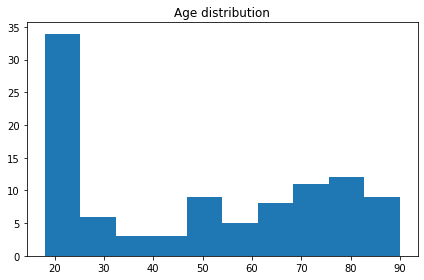

In [31]:
# We can check that the age distribution makes sense
import matplotlib.pyplot as plt
plt.hist(age)
plt.title('Age distribution')
plt.tight_layout()

In [32]:
# Split data into training set and test set
from sklearn.model_selection import train_test_split
gm_imgs_train, gm_imgs_test, age_train, age_test = train_test_split(
    gray_matter_map_filenames, age, train_size=.6, random_state=0)

In [33]:
masker = NiftiMasker(standardize=False,
                     smoothing_fwhm=2)
gm_maps_masked = masker.fit_transform(gm_imgs_train)
gm_maps_masked.shape

(60, 902629)

In [34]:
# The features with too low between-subject variance are removed 
from sklearn.feature_selection import VarianceThreshold

variance_threshold = VarianceThreshold(threshold=.01)
gm_maps_thresholded = variance_threshold.fit_transform(gm_maps_masked)
gm_maps_masked = variance_threshold.inverse_transform(gm_maps_thresholded)
gm_maps_masked.shape

(60, 902629)

In [35]:
# Then we convert the data back to the mask image in order to use it for
# decoding process
mask = masker.inverse_transform(variance_threshold.get_support())
mask.shape

(91, 109, 91)

In [36]:
decoder = DecoderRegressor(estimator='svr', mask=mask,
                           scoring='neg_mean_absolute_error',
                           screening_percentile=1,
                           n_jobs=1)
# Fit and predict with the decoder
decoder.fit(gm_imgs_train, age_train)

In [37]:
# Sort test data for better visualization (trend, etc.)
perm = np.argsort(age_test)[::-1]
age_test = age_test[perm]
gm_imgs_test = np.array(gm_imgs_test)[perm]
age_pred = decoder.predict(gm_imgs_test)

prediction_score = -np.mean(decoder.cv_scores_['beta'])

print("explained variance for the cross-validation: %f" % prediction_score)

explained variance for the cross-validation: 10.670598


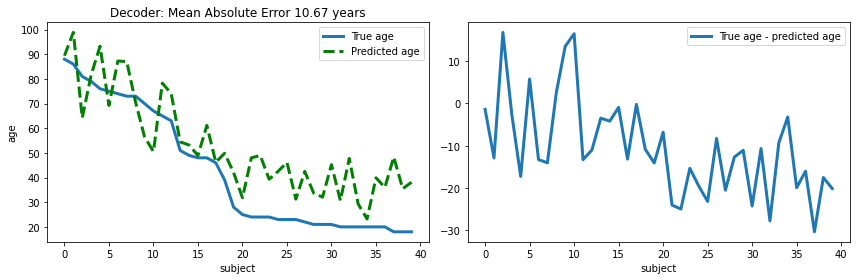

In [38]:
linewidth = 3
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(121)
ax.plot(age_test, label="True age", linewidth=linewidth)
ax.plot(age_pred, '--', c="g", label="Predicted age", linewidth=linewidth)
ax.set_ylabel("age")
ax.set_xlabel("subject")
ax.legend(loc="best")
ax.set_title("Decoder: Mean Absolute Error %.2f years" % prediction_score)
ax2 = fig.add_subplot(122)
ax2.plot(age_test - age_pred, label="True age - predicted age", linewidth=linewidth)
ax2.set_xlabel("subject")
ax2.legend(loc="best")
plt.tight_layout()

We can also visualize the SVM weights as a brain image using the function `plot_stat_map` from the `plotting` module:

/home/nicolas/GitRepos/nilearn-fork/nilearn/plotting/displays.py:1750: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fh.add_axes([fraction * index * (x1 - x0) + x0, y0,


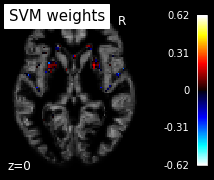

In [39]:
from nilearn.plotting import plot_stat_map

weight_img = decoder.coef_img_['beta']
bg_filename = gray_matter_map_filenames[0]
z_slice = 0
display = plot_stat_map(weight_img,
                        bg_img=bg_filename,
                        display_mode='z', 
                        cut_coords=[z_slice], 
                        colorbar=True)
display.title("SVM weights")

<span id="references"></span>

## IV - References

Here are a few pointers to additional ressources related to decoding:

- [Decoder doc](http://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html#nilearn.decoding.Decoder)
- [DecoderRegressor doc](http://nilearn.github.io/modules/generated/nilearn.decoding.DecoderRegressor.html#nilearn.decoding.DecoderRegressor)
- [Nilearn Decoding Tutorial](http://nilearn.github.io/decoding/index.html)
- [Decoding with ANOVA + SVM](http://nilearn.github.io/auto_examples/02_decoding/plot_haxby_anova_svm.html#sphx-glr-auto-examples-02-decoding-plot-haxby-anova-svm-py)
- [Decoding of a dataset after GLM fit for signal extraction](http://nilearn.github.io/auto_examples/02_decoding/plot_haxby_glm_decoding.html#sphx-glr-auto-examples-02-decoding-plot-haxby-glm-decoding-py)
- [Voxel-Based Morphometry on Oasis dataset](http://nilearn.github.io/auto_examples/02_decoding/plot_oasis_vbm.html#sphx-glr-auto-examples-02-decoding-plot-oasis-vbm-py)